# Design Space Exploration with Draco

This Jupyter Notebook follows the comprehensive guide provided in [Draco's documentation](https://dig.cmu.edu/draco2/applications/design_space_exploration.html#inspecting-the-knowledge-base).

In this notebook, we will explore the design space relevant to our specific context and datasets.


## Importing all necessary libraries

In [42]:
import json
import draco
import altair as alt
from draco.renderer import AltairRenderer
from draco.debug import DracoDebug, DracoDebugChartConfig, DracoDebugPlotter
from app.services.temp_file_management import create_temp_file
from app.services.draco_service import get_draco_dataframe,get_draco_facts,get_draco_schema
import numpy as np
from IPython.display import Markdown, display
from tqdm import tqdm

### Display utilities

In [43]:
# Handles serialization of common numpy datatypes
class NpEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.integer):
            return int(obj)
        elif isinstance(obj, np.floating):
            return float(obj)
        elif isinstance(obj, np.ndarray):
            return obj.tolist()
        else:
            return super(NpEncoder, self).default(obj)


def md(markdown: str):
    display(Markdown(markdown))


def pprint(obj):
    md(f"```json\n{json.dumps(obj, indent=2, cls=NpEncoder)}\n```")


## Special Notebook draco_rec_compute

Here we redefine draco_rec_compute so that we can use the display capacities of Jupyter Notebooks.

In [44]:

default_input_spec=[
    "entity(view,root,v0).",
    "entity(mark,v0,m0).",
]
def draco_rec_compute(data,specs:list[str]= default_input_spec,num_chart:int = 5, labeler=lambda i: f"CHART {i + 1}", Debug: bool=False):
    """
    Computes and recommends Draco charts based on the input data.

    Parameters:
    data (JSON): The raw input data to be processed.
    num_chart (int, optional): The number of charts to recommend. Default is 5.
    Debug(bool, optional):Debug mode, writes chart_specs_outpute to json files in ./data/events/temps/. Default is False.
    
    Returns:
    dict: A dictionary containing the recommended chart specifications and their renderings.
    """
    
    d = draco.Draco()
    renderer = AltairRenderer()
    draco_data=get_draco_dataframe(data)
    draco_facts=get_draco_facts(get_draco_schema(draco_data))
    input_spec_base = draco_facts + specs
    #print("\n\n\n///////////input_spec_base:\n",input_spec_base)
    if Debug:
        alt.renderers.enable("svg")

    
    def recommend_charts(
    spec: list[str], drc: draco.Draco, num: int = 2, labeler=lambda i: f"CHART {i + 1}"
):
        # Dictionary to store the generated recommendations, keyed by chart name
        chart_specs = {}
        
        for i, model in enumerate(drc.complete_spec(spec, num)):
            
            chart_name = labeler(i)
            schema = draco.answer_set_to_dict(model.answer_set)

            #print("draco spec",chart_specs[chart_name])
            #print(f"COST: {model.cost}")
            
            #computing vega lite spec for current recommendation
            chart_vega_lite = renderer.render(spec=schema, data=draco_data)
            if Debug:
                display(chart_vega_lite)
            chart_specs[chart_name] = draco.dict_to_facts(schema), schema
            #chart_specs[chart_name] = chart_vega_lite
            
            
        return chart_specs

    return recommend_charts(input_spec_base,d,num_chart)


Usage example :

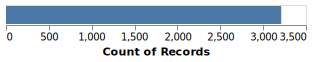

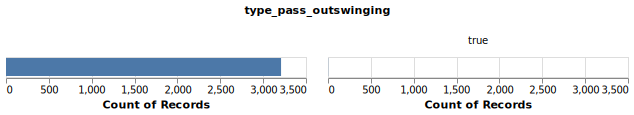

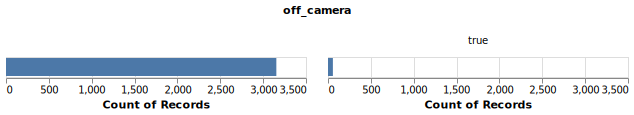

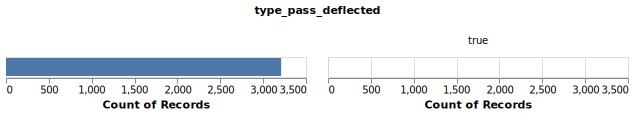

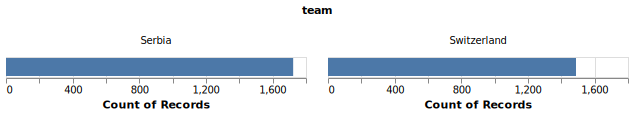

In [45]:
file_path = create_temp_file("3857256")
with open(file_path, 'r') as file:
    data = json.load(file)
    chart_specs=draco_rec_compute(data,Debug=True)

## Inspecting the Knowledge Base

In [46]:

def display_debug_data(draco: draco.Draco, specs: dict[str, tuple[list[str], dict]]):
    debugger = DracoDebug(
        specs={chart_name: fact_spec for chart_name, (fact_spec, _) in specs.items()},
        draco=draco,
    )
    chart_preferences = debugger.chart_preferences
    display(Markdown("**Raw debug data**"))
    display(chart_preferences.head())

    display(Markdown("**Number of violated preferences**"))
    num_violations = len(
        set(chart_preferences[chart_preferences["count"] != 0]["pref_name"])
    )
    num_all = len(set(chart_preferences["pref_name"]))
    display(
        Markdown(
            f"*{num_violations} preferences are violated out of a total of {num_all} preferences (soft constraints)*"
        )
    )

    display(
        Markdown(
            "Using `DracoDebugPlotter` to visualize the debug `DataFrame` produced by `DracoDebug`:"
        )
    )
    plotter = DracoDebugPlotter(chart_preferences)
    plot_size = (1200, 600)
    chart = plotter.create_chart(
        cfg=DracoDebugChartConfig.SORT_BY_COUNT_SUM,
        violated_prefs_only=False,
        plot_size=plot_size,
    )
    chart.show()  # <-- If using Altair/VegaLite backend; else: export to HTML or save

**Raw debug data**

,chart_name,pref_name,pref_description,count,weight
0,CHART 1,cartesian_coordinate,Cartesian coordinates.,1,0
1,CHART 1,summary_bar,Bar mark for summary tasks.,1,0
2,CHART 1,aggregate_count,Count as aggregate op.,1,0
3,CHART 1,linear_x,Linear scale with x channel.,1,0
4,CHART 1,c_d_no_overlap_bar,Continuous by discrete for bar mark.,1,0


**Number of violated preferences**

*11 preferences are violated out of a total of 147 preferences (soft constraints)*

Using `DracoDebugPlotter` to visualize the debug `DataFrame` produced by `DracoDebug`:

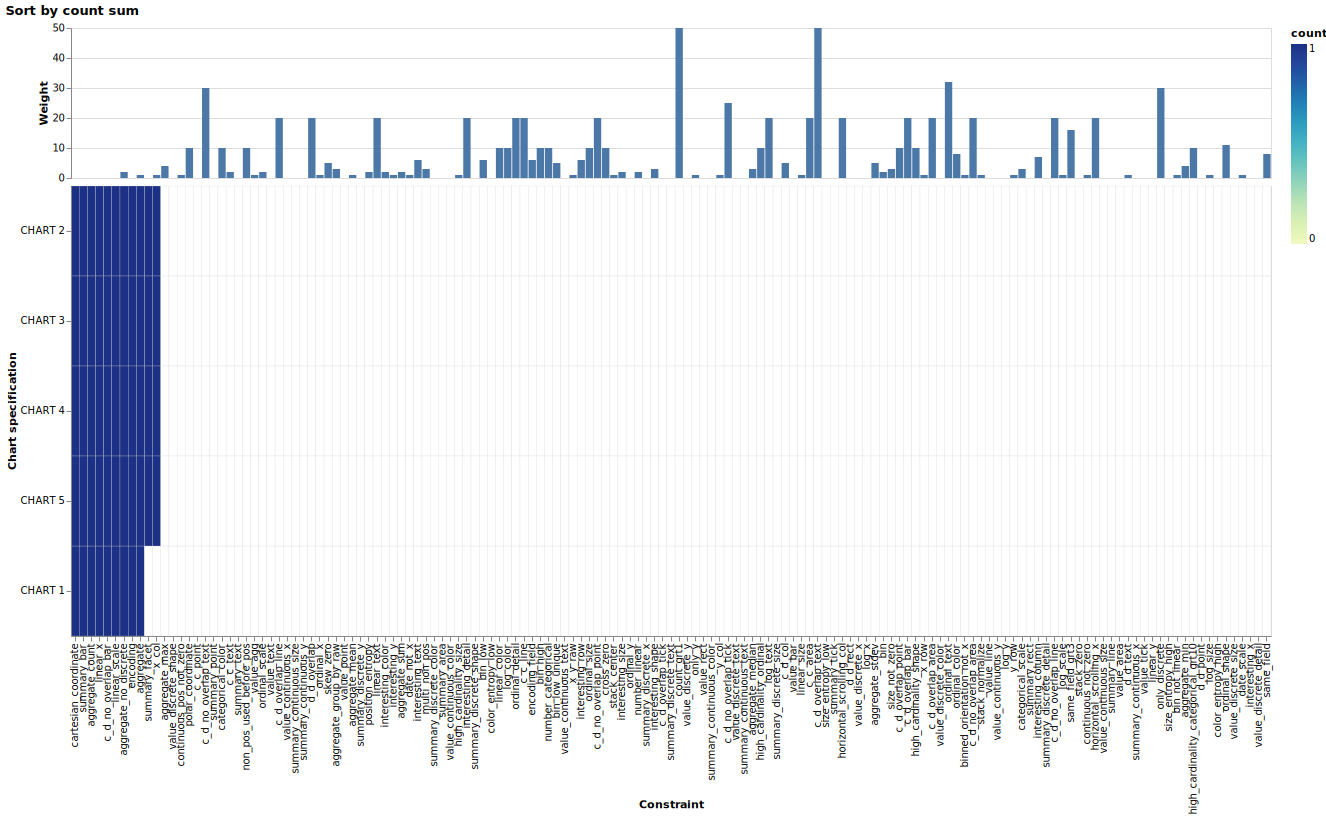

In [47]:
d = draco.Draco()
renderer = AltairRenderer()
alt.renderers.enable("svg")
display_debug_data(draco=d, specs=chart_specs)

## Generating Input Specifications Programmatically


In [48]:
def rec_from_generated_spec(data,
    marks: list[str],
    fields: list[str],
    encoding_channels: list[str],
    draco: draco.Draco,
    num: int = 1,
) -> dict[str, dict]:
    input_specs = [
        (
            (mark, field, enc_ch),
            input_spec_base
            + [
                f"attribute((mark,type),m0,{mark}).",
                "entity(encoding,m0,e0).",
                f"attribute((encoding,field),e0,{field}).",
                f"attribute((encoding,channel),e0,{enc_ch}).",
                # filter out designs with less than 3 encodings
                ":- {entity(encoding,_,_)} < 3.",
                # exclude multi-layer designs
                ":- {entity(mark,_,_)} != 1.",
            ],
        )
        for mark in marks
        for field in fields
        for enc_ch in encoding_channels
    ]
    #print(input_specs)
    recs = {}
    for cfg, spec in tqdm(input_specs, desc="Processing input specifications"):        
        def labeler(i):
            f"CHART {i + 1} ({' | '.join(cfg)})"
        recs |= draco_rec_compute(data, specs=spec, num_chart=num, labeler=labeler,Debug=True)
        #print(recs)
    return recs

Fetching the dataset and creating another, simple, partial specs:

In [49]:
test_specs = [
"entity(view,root,v).",
"attribute((view,coordinates),v,cartesian).",

"entity(mark,v,m).",
"attribute((mark,type),m,tick).",
]
with open(file_path, 'r') as file:
    data = json.load(file)
    draco_data=get_draco_dataframe(data)
    draco_facts=get_draco_facts(get_draco_schema(draco_data))
    input_spec_base = draco_facts + test_specs

Processing input specifications:  75%|██████████████████████████████████████████████████████████████████████████████████████▎                            | 27/36 [00:22<00:07,  1.19it/s]

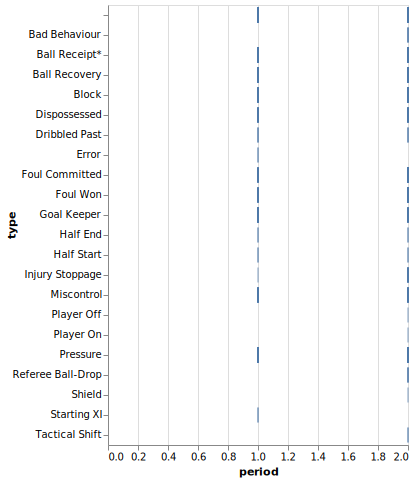

Processing input specifications:  83%|███████████████████████████████████████████████████████████████████████████████████████████████▊                   | 30/36 [00:25<00:05,  1.09it/s]

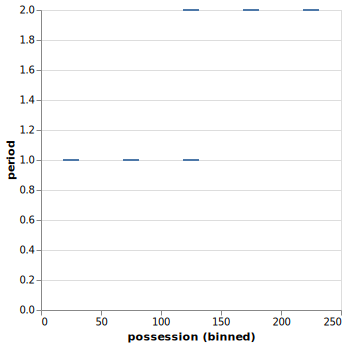

Processing input specifications:  92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 33/36 [00:28<00:02,  1.07it/s]

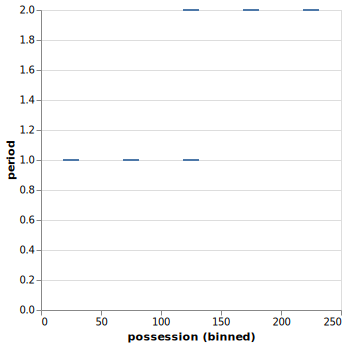

Processing input specifications: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 36/36 [00:31<00:00,  1.13it/s]


In [50]:
recommendations = rec_from_generated_spec(data,
        marks=["point", "bar", "line", "rect"],
        fields=["timestamp", "team", "type_name"],
        encoding_channels=["color", "shape", "size"],
        draco=d,)

Checking constraint violation

**Raw debug data**

,chart_name,pref_name,pref_description,count,weight
0,CHART 1,cartesian_coordinate,Cartesian coordinates.,1,0
1,CHART 1,summary_bar,Bar mark for summary tasks.,1,0
2,CHART 1,aggregate_count,Count as aggregate op.,1,0
3,CHART 1,linear_x,Linear scale with x channel.,1,0
4,CHART 1,c_d_no_overlap_bar,Continuous by discrete for bar mark.,1,0


**Number of violated preferences**

*11 preferences are violated out of a total of 147 preferences (soft constraints)*

Using `DracoDebugPlotter` to visualize the debug `DataFrame` produced by `DracoDebug`:

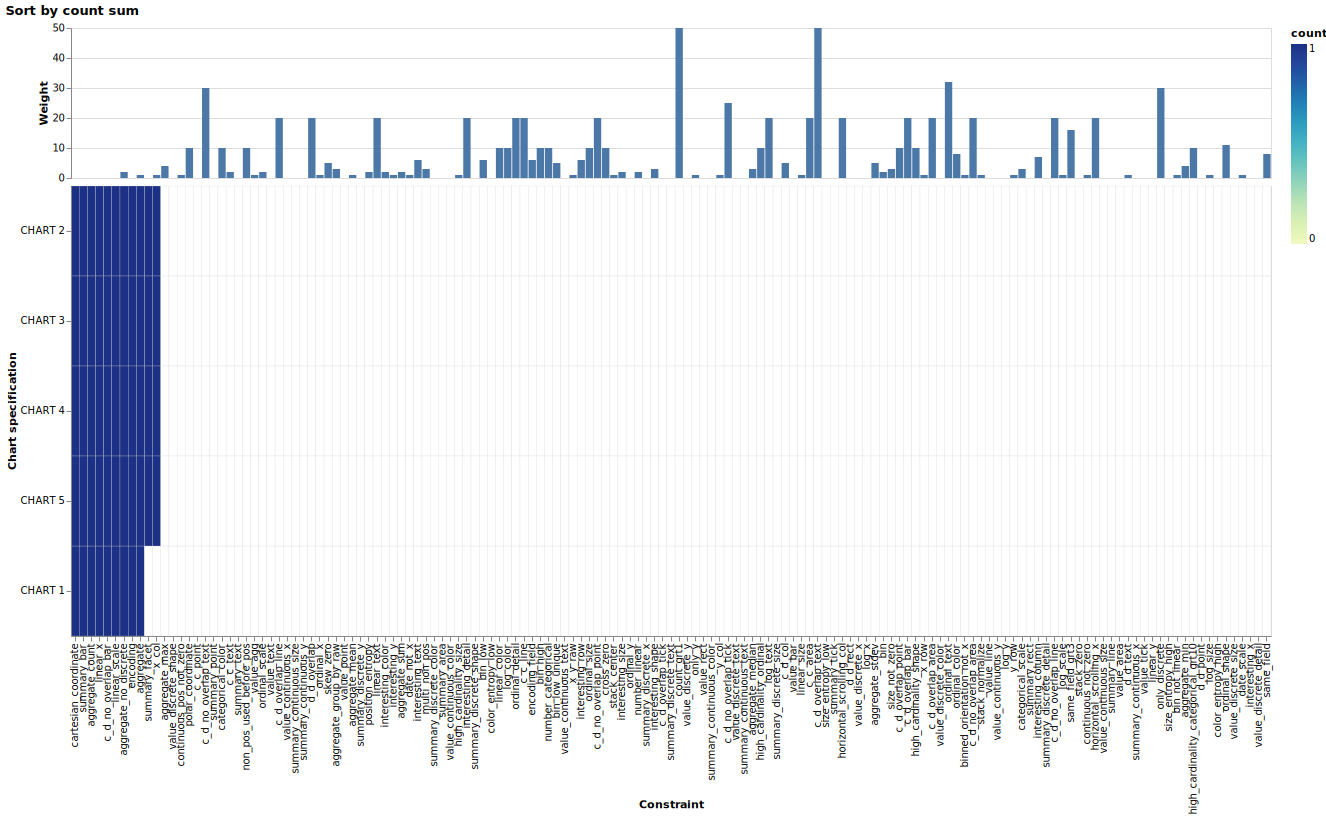

In [51]:
display_debug_data(draco=d, specs=chart_specs)

## Adjusting the Knowledge Base


Function to add new soft constraints to the Draco model.

In [52]:
def draco_add_soft_constraint(drc: draco.Draco,
    new_constraints: list[tuple[str, int, str]]
) -> draco.Draco:
    """
    Update Draco with new soft constraints.

    Parameters:
    - new_constraints: List of tuples (constraint_name, weight, constraint_str)

    Returns:
    - draco.Draco object with updated soft program and weights
    """
    
    soft_updated = drc.soft
    weights_updated = drc.weights.copy()

    for name, weight, constraint_str in new_constraints:
        constraint_str = constraint_str.strip()
        # Prepend metadata comment
        annotated = f"% @soft({name})\n{constraint_str}"
        soft_updated += f"\n\n{annotated}"
        weights_updated[f"{name}_weight"] = weight

    return draco.Draco(soft=soft_updated, weights=weights_updated)


### Trying out new constraints

Generic constraints :

In [53]:
# Soft constraints to guide better visualizations
constraints = [
    (
        "avoid_high_cardinality_color", 10,
        """
        preference(avoid_high_cardinality_color, E) :-
            entity(encoding, _, E),
            attribute((encoding,channel), E, color),
            attribute((encoding,field), E, F),
            attribute((field,type), F, string),
            attribute((field,unique), F, U), U > 20.
        """
    ),
    (
        "prefer_temporal_on_x", 8,
        """
        preference(prefer_temporal_on_x, E) :-
            entity(encoding, _, E),
            attribute((encoding,channel), E, x),
            attribute((encoding,field), E, F),
            attribute((field,name), F, "timestamp").
        """
    ),
    (
        "avoid_id_in_encoding", 9,
        """
        preference(avoid_id_in_encoding, E) :-
            entity(encoding, _, E),
            attribute((encoding,field), E, F),
            attribute((field,name), F, "id").
        """
    ),
    (
        "prefer_high_std_on_y", 6,
        """
        preference(prefer_high_std_on_y, E) :-
            entity(encoding, _, E),
            attribute((encoding,channel), E, y),
            attribute((encoding,field), E, F),
            attribute((field,std), F, S), S > 5.
        """
    )
]

Trying to block irrelevant data fields such period, id, or possesion, to be considered:

In [ ]:
irrelevant_constraints = [
    (
        "avoid_id_field", 10,
        """
        preference(avoid_id_field, E) :-
            entity(encoding, _, E),
            attribute((encoding,field), E, F),
            attribute((field,name), F, "id").
        """
    ),
    (
        "avoid_index_field", 10,
        """
        preference(avoid_index_field, E) :-
            entity(encoding, _, E),
            attribute((encoding,field), E, F),
            attribute((field,name), F, "index").
        """
    ),
    (
        "avoid_timestamp_field", 10,
        """
        preference(avoid_timestamp_field, E) :-
            entity(encoding, _, E),
            attribute((encoding,field), E, F),
            attribute((field,name), F, "timestamp").
        """
    ),
    (
        "avoid_play_pattern_field", 7,
        """
        preference(avoid_play_pattern_field, E) :-
            entity(encoding, _, E),
            attribute((encoding,field), E, F),
            attribute((field,name), F, "play_pattern").
        """
    )
]

**Generating new Draco instance with these soft constraints**


In [55]:
custom_draco = draco_add_soft_constraint(d,irrelevant_constraints)

Trying out the new constraints:

Processing input specifications:   0%|                                                                                                                             | 0/2 [00:00<?, ?it/s]

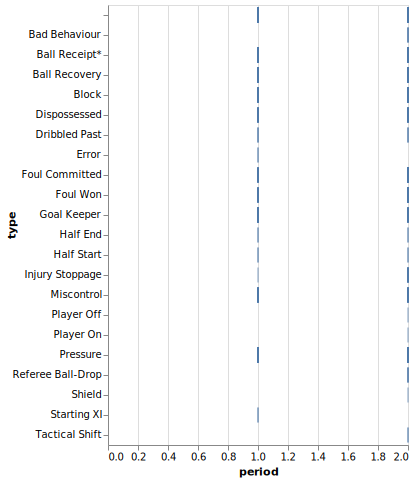

Processing input specifications:  50%|██████████████████████████████████████████████████████████▌                                                          | 1/2 [00:01<00:01,  1.84s/it]

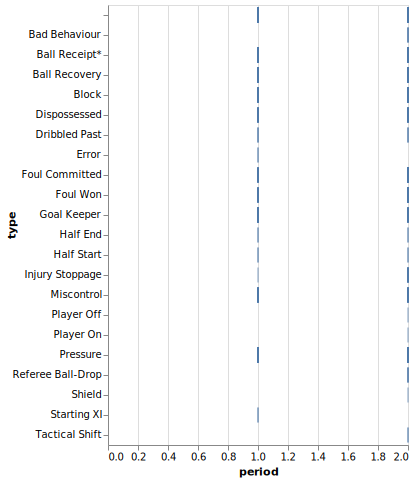

Processing input specifications: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.85s/it]


**Raw debug data**

,chart_name,pref_name,pref_description,count,weight
0,CHART 1,cartesian_coordinate,Cartesian coordinates.,1,0
1,CHART 1,summary_tick,Tick mark for summary tasks.,1,0
2,CHART 1,ordinal_y,Ordinal scale with y channel.,1,0
3,CHART 1,linear_x,Linear scale with x channel.,1,0
4,CHART 1,c_d_overlap_tick,Continuous by discrete for tick mark.,1,0


**Number of violated preferences**

*9 preferences are violated out of a total of 151 preferences (soft constraints)*

Using `DracoDebugPlotter` to visualize the debug `DataFrame` produced by `DracoDebug`:

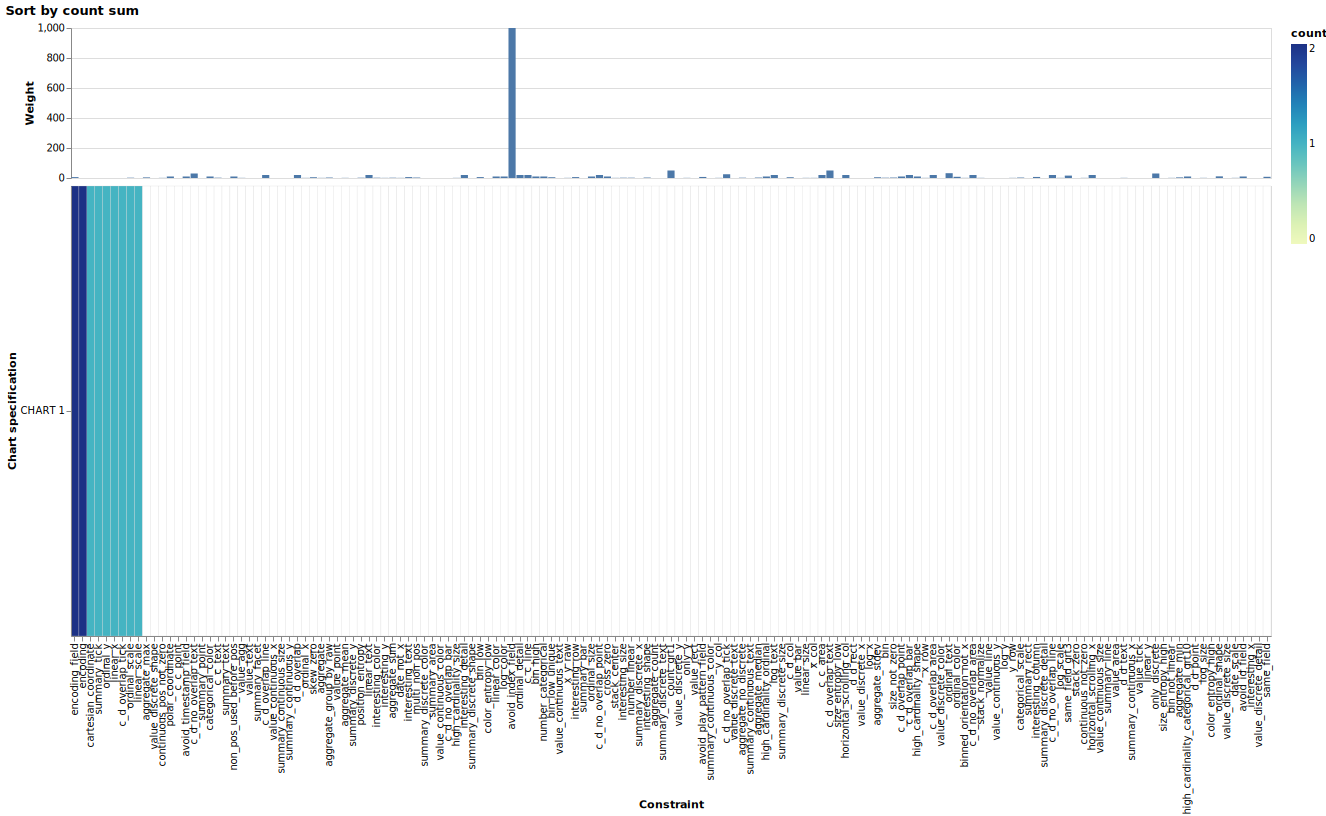

In [57]:
recommendations = rec_from_generated_spec(data,
    marks=["rect"],
    fields=["timestamp", "id"],
    encoding_channels=["color"],
    draco=custom_draco,
)
display_debug_data(draco=custom_draco, specs=recommendations)
